In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio

mpl.rcParams['figure.figsize'] = [14.0, 6.0]

In [2]:
max_safe_exponent = np.log(2)*(np.finfo(float).maxexp-1)

def bump_function(t, t0, t1):
    """Smooth function going from 0 before t0 to 1 after t1, with C^infty transition in between"""
    assert t0 <= t1
    f = np.zeros_like(t)
    if t0 >= t[-1]:
        return f
    f[t >= (t0+t1)/2] = 1.0
    if t1 <= t[0]:
        return f
    transition_indices = (t0 < t) & (t < t1)
    transition = (t[transition_indices]-t0) / (t1 - t0)
    transition = 1.0/transition - 1.0/(1.0-transition)
    safe_indices = (transition < max_safe_exponent)
    transition_indices[transition_indices] = safe_indices
    f[transition_indices] = 1.0 / (1.0 + np.exp(transition[safe_indices]))
    return f

In [8]:
sampling_rate = 4096.0 # Hz
with h5py.File('Data/H-H1_LOSC_4_V1-1126259446-32.hdf5') as f:
    h = f['strain/Strain'][:]
    # Time of event is 16.4

# sampling_rate = 4096.0 # Hz
# with h5py.File('Data/L-L1_LOSC_4_V1-1126259446-32.hdf5') as f:
#     h = f['strain/Strain'][:]
#     # Time of event is 16.4

# sampling_rate = 4096.0 # Hz
# with h5py.File('Data/H-H1_LOSC_16_V1-1135136334-32.hdf5') as f:
#     h = f['strain/Strain'][:]
#     h = signal.decimate(h, 4, 60, ftype='fir')
#     # Time of event is 16.65

dt = 1/sampling_rate
t = np.arange(len(h)) / sampling_rate
htilde = dt * np.fft.rfft(h)
frequencies = np.fft.rfftfreq(len(h), dt)

<IPython.core.display.Javascript object>


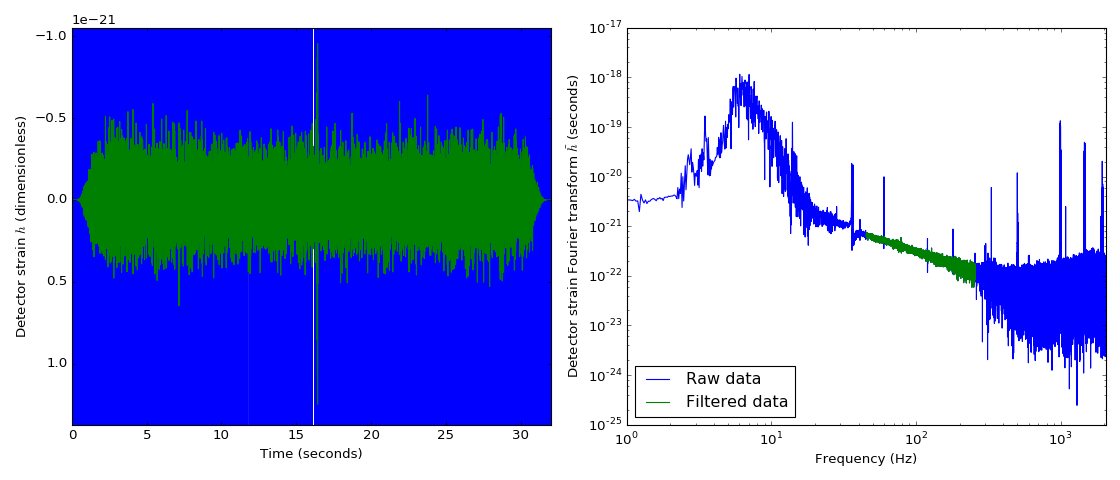

In [11]:
def filter_and_plot(sliders, notch_filters):
    # Once new output is available, clear the old output
    clear_output(wait=True)

    # Get levels from sliders
    levels = np.ones_like(frequencies)
    slider_values = [s.value for s in sliders]
    for i, f in enumerate(frequency_bin_upper_ends):
        if i==0:
            f_last = 0.0
        levels[(frequencies >= f_last) & (frequencies < f)] = slider_values[i]/100.0
        f_last = f

    # Get notch filters (if any)
    for notch_filter in notch_filters.children:
        f_begin, f_end, f_bool = [child.value for child in notch_filter.children if not isinstance(child, widgets.Label)]
        if (f_bool is True) and (f_begin<f_end):
            levels[(frequencies >= f_begin) & (frequencies < f_end)] = 0.0
    
    # Filter the data
    hprime = (1/dt) * np.fft.irfft(htilde*levels)
    
    # Smooth the beginning and end, so there are no loud spikes as the audio turns on and off
    hprime *= bump_function(t, 0, 3.0) * (1-bump_function(t, t[-1]-3.0, t[-1]))
    
    # Plot
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(t, h)
    ax1.plot(t, hprime)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Detector strain $h$ (dimensionless)')
    ax1.set_xlim(xmax=t[-1])
    ax1.set_ylim(1.1*np.max(hprime), 1.1*np.min(hprime));
    ax2.loglog(frequencies, abs(htilde), label='Raw data')
    ax2.loglog(frequencies, abs(htilde*levels), label='Filtered data')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel(r'Detector strain Fourier transform $\tilde{h}$ (seconds)')
    ax2.set_xlim(1, sampling_rate/2)
    ax2.legend(loc='lower left');
    f.tight_layout()
    display(Audio(data=hprime, rate=int(sampling_rate), autoplay=False))
    

log2_sampling_rate = int(np.log2(sampling_rate/2))
frequency_bin_upper_ends = np.logspace(3, log2_sampling_rate, num=2*(log2_sampling_rate-3)+1, base=2)

gap_filler = widgets.Label("", layout=widgets.Layout(flex='1 1 auto'))
labels = widgets.VBox([widgets.Label("Frequency (Hz)"), gap_filler, widgets.Label("Amplitude (%)")], width='110px')
separator = widgets.VBox([], border='1px solid #ccc', width='0px')

sliders = [widgets.FloatSlider(min=0, max=100, step=1.0, value=100.0, height='auto', readout_format='.0f',
                               orientation='vertical', padding=6, description=str(int(freq)))
           for freq in frequency_bin_upper_ends]

equalizer = widgets.HBox(children=[labels, separator]+sliders+[separator], width='{0}px'.format(100*len(sliders)), height='200px')
display(equalizer)

notch_filters = widgets.VBox([], width='450px')
def add_notch_filter():
    new_filter = widgets.HBox([widgets.FloatText(description='Begin', width='150px'),
                               widgets.FloatText(description='End', width='150px'),
                               gap_filler,
                               widgets.Checkbox(description='Use filter', value=True)])
    notch_filters.children += (new_filter,)
add_notch_filters = widgets.Button(description="Add notch filters")
add_notch_filters.on_click(lambda change: add_notch_filter())
display(add_notch_filters)
display(notch_filters)

recalculate = widgets.Button(description='Recalculate')
recalculate.on_click(lambda change: filter_and_plot(sliders, notch_filters))
display(recalculate)

# CHEAT!!!
for f,s in zip(frequency_bin_upper_ends, sliders):
    if f<63 or f>257:
        s.value = 0.0

notch_filters.children = tuple(widgets.HBox([widgets.FloatText(value=e, description='Begin', width='150px'),
                                             widgets.FloatText(value=b, description='End', width='150px'),
                                             gap_filler,
                                             widgets.Checkbox(description='Use filter', value=True)])
                               for e,b in [(59.8, 60.2), (119.5, 120.5), (179.0, 181.0)])
#                                for e,b in [(59.8, 60.2), (119.5, 120.5), (179.0, 181.0), (35.5, 37.0), (40.85, 41.1)])
#                                for e,b in [(59., 61.), (119.5, 120.5), (179.0, 181.0), (35.5, 37.0), (40.85, 41.1), (299., 304.), (331.4, 334.0)])


filter_and_plot(sliders, notch_filters)